In [99]:
!pip install aiosqlite


In [1]:
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')


In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.


# Lesson 1: Simple ReAct Agent from Scratch

In [3]:
# based on https://til.simonwillison.net/llms/python-react-pattern

In [4]:
import openai
import re
import httpx
import os
from dotenv import load_dotenv

_ = load_dotenv()
from openai import OpenAI

In [5]:
client = OpenAI()

In [6]:
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)

In [7]:
chat_completion.choices[0].message.content

'Hello! How can I assist you today?'

In [8]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o",
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content


In [9]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [10]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier":
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [11]:
abot = Agent(prompt)

In [12]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a Toy Poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [13]:
result = average_dog_weight("Toy Poodle")

In [14]:
result

'a toy poodles average weight is 7 lbs'

In [15]:
next_prompt = "Observation: {}".format(result)

In [16]:
abot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

In [17]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [18]:
abot = Agent(prompt)

In [19]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to find the combined weight.\nAction: average_dog_weight: Border Collie\nPAUSE'

In [20]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [21]:
abot(next_prompt)

'Action: average_dog_weight: Scottish Terrier\nPAUSE'

In [22]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [23]:
abot(next_prompt)

'Thought: Now that I have the average weights of both dogs, I can calculate their combined weight by adding them together.\nAction: calculate: 37 + 20\nPAUSE'

In [24]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [25]:
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

### Add loop

In [26]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

In [27]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [28]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to find the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.


# Lesson 2 : LangGraph Components

In [29]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [30]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [31]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [32]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [33]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

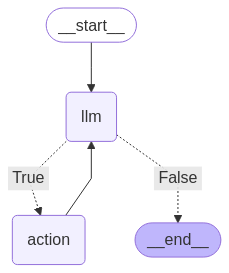

In [39]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = abot.graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

In [40]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_qNwQ77EhfKc9QBiuKsToHMwm', 'type': 'tool_call'}
Back to the model!


In [41]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qNwQ77EhfKc9QBiuKsToHMwm', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 153, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18cde3c8-10f4-43c1-b8cb-9ed84c6d5d39-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_qNwQ77EhfKc9QBiuKsToHMwm', 'type': 'tool_call'}],

In [42]:
result['messages'][-1].content

'The current weather in San Francisco is clear with a temperature of 57.0°F (13.9°C). The wind speed is 8.7 mph (14.0 km/h) coming from the west. The humidity is at 67% with a visibility of 9.0 miles.'

In [43]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_jwWFczbLiqfcrEeDHMY3bizH', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_DjDRIGV5V1Vk2PuH9BDtRywF', 'type': 'tool_call'}
Back to the model!


In [44]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_LsLy8TziL4cshxbg3KcHLg74', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of the state where 2024 Super Bowl winning team is based'}, 'id': 'call_7jCZC7XJ3C1hJG0zAiNFWtq7', 'type': 'tool_call'}
Back to the model!


In [45]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**

   The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**

   The Kansas City Chiefs are headquartered in Missouri.

3. **What is the GDP of that state?**

   I currently do not have the specific GDP figure for Missouri from the search. Would you like me to search again for the most recent GDP figure for Missouri?


# Lesson 3: Agentic Search

In [46]:
# libraries
from dotenv import load_dotenv
import os
from tavily import TavilyClient

# connect
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [47]:
# run search
result = client.search("What is in Nvidia's new Blackwell GPU?",
                       include_answer=True)

# print the answer
result["answer"]


'The Blackwell GPU features fifth-generation NVLink, a second-generation Transformer Engine, and supports up to 576 GPUs. It offers up to 20 petaflops of compute performance and is designed for generative AI.'

## Regular search

In [49]:
# choose location (try to change to your own city!)

city = "San Francisco"

query = f"""
    what is the current weather in {city}?
    Should I travel there today?
    "weather.com"
"""

In [50]:
import requests
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
import re

ddg = DDGS()

def search(query, max_results=6):
    try:
        results = ddg.text(query, max_results=max_results)
        return [i["href"] for i in results]
    except Exception as e:
        print(f"returning previous results due to exception reaching ddg.")
        results = [ # cover case where DDG rate limits due to high deeplearning.ai volume
            "https://weather.com/weather/today/l/USCA0987:1:US",
            "https://weather.com/weather/hourbyhour/l/54f9d8baac32496f6b5497b4bf7a277c3e2e6cc5625de69680e6169e7e38e9a8",
        ]
        return results


for i in search(query):
    print(i)

https://weather.com/weather/today/l/San+Francisco+CA+USCA0987
https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US
https://weather.com/weather/tenday/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678
https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US
https://weather.com/weather/today/l/Seattle+WA?canonicalCityId=1138ce33fd1be51ab7db675c0da0a27c
https://weather.com/weather/hourbyhour/l/South+San+Francisco+CA?canonicalCityId=65b48c0711b50d6a3bc98e64e000e2b23391bb4f0a911573aede03494b9e7fa9


In [51]:
def scrape_weather_info(url):
    """Scrape content from the given URL"""
    if not url:
        return "Weather information could not be found."

    # fetch data
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the webpage."

    # parse result
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup


In [52]:
# use DuckDuckGo to find websites and take the first result
url = search(query)[0]

# scrape first wesbsite
soup = scrape_weather_info(url)

print(f"Website: {url}\n\n")
print(str(soup.body)[:50000]) # limit long outputs

returning previous results due to exception reaching ddg.
Website: https://weather.com/weather/today/l/USCA0987:1:US


<body><div class="appWrapper DaybreakLargeScreen LargeScreen lightTheme twcTheme DaybreakLargeScreen--appWrapper--ZkDop gradients--clearNight--cs6t9 gradients--clearNight-top--SVtBt" id="appWrapper"><div class="region-meta"><div class="removeIfEmpty" id="WxuHtmlHead-meta-"></div><div class="removeIfEmpty" id="WxuNewsroom-meta-bc9f40d5-d941-4fd8-bae2-2d8d63a38bb3"></div></div><div class="region-topAds regionTopAds DaybreakLargeScreen--regionTopAds--sDajQ"><div class="removeIfEmpty" id="WxuAd-topAds-53dce052-5465-4609-a555-c3a20ab64ab0"><div class="adWrapper BaseAd--adWrapper--ANZ1O BaseAd--card--cqv7t BaseAd--hide--hCG8L"><div class="adLabel BaseAd--adLabel--JGSp6">Advertisement</div><div class="ad_module BaseAd--ad_module--ajh9S subs-undefined BaseAd--placeholder--ofteC" id="WX_Hidden"></div></div></div><div class="removeIfEmpty" id="WxuAd-topAds-fe926b10-58bc-448a-ab0

In [53]:
# extract text
weather_data = []
for tag in soup.find_all(['h1', 'h2', 'h3', 'p']):
    text = tag.get_text(" ", strip=True)
    weather_data.append(text)

# combine all elements into a single string
weather_data = "\n".join(weather_data)

# remove all spaces from the combined text
weather_data = re.sub(r'\s+', ' ', weather_data)

print(f"Website: {url}\n\n")
print(weather_data)

Website: https://weather.com/weather/today/l/USCA0987:1:US


recents Weather Forecasts Radar & Maps News & Media Products Health & Wellness Account Lifestyle Privacy Specialty Forecasts San Francisco, CA Small Craft Advisory Weather Today in San Francisco, CA 6:04 am 8:08 pm Morning Afternoon Evening Overnight Don't Miss Hourly Forecast Now 10 pm 11 pm 12 am 1 am Seasonal Hub Trending Now Daily Forecast Today Sun 11 Mon 12 Tue 13 Wed 14 Radar We Love Our Critters Fighting Allergies Home, Garage & Garden Disney In The Desert Keeping You Healthy Product Reviews & Deals Everything You Need To Know About Portable Air Conditioners 39 Unique Mother’s Day Gift Ideas Best Mother’s Day Flower Delivery Services Bad Allergies? Help Control Symptoms With These Air Purifiers Happening Near San Francisco, CA Popular Nextdoor posts Stay Safe Reminder For Drinking Water Air Quality Index Air quality is considered satisfactory, and air pollution poses little or no risk. Health & Activities Seasonal All

## Agentic Search

In [54]:
# run search
result = client.search(query, max_results=1)

# print first result
data = result["results"][0]["content"]

print(data)

{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1746939379, 'localtime': '2025-05-10 21:56'}, 'current': {'last_updated_epoch': 1746938700, 'last_updated': '2025-05-10 21:45', 'temp_c': 13.9, 'temp_f': 57.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 8.7, 'wind_kph': 14.0, 'wind_degree': 265, 'wind_dir': 'W', 'pressure_mb': 1014.0, 'pressure_in': 29.95, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 67, 'cloud': 25, 'feelslike_c': 12.8, 'feelslike_f': 55.1, 'windchill_c': 10.8, 'windchill_f': 51.5, 'heatindex_c': 12.2, 'heatindex_f': 54.0, 'dewpoint_c': 10.0, 'dewpoint_f': 50.1, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, 'gust_mph': 15.1, 'gust_kph': 24.4}}


In [55]:
import json
from pygments import highlight, lexers, formatters

# parse JSON
parsed_json = json.loads(data.replace("'", '"'))

# pretty print JSON with syntax highlighting
formatted_json = json.dumps(parsed_json, indent=4)
colorful_json = highlight(formatted_json,
                          lexers.JsonLexer(),
                          formatters.TerminalFormatter())

print(colorful_json)


{
    "location": {
        "name": "San Francisco",
        "region": "California",
        "country": "United States of America",
        "lat": 37.775,
        "lon": -122.4183,
        "tz_id": "America/Los_Angeles",
        "localtime_epoch": 1746939379,
        "localtime": "2025-05-10 21:56"
    },
    "current": {
        "last_updated_epoch": 1746938700,
        "last_updated": "2025-05-10 21:45",
        "temp_c": 13.9,
        "temp_f": 57.0,
        "is_day": 0,
        "condition": {
            "text": "Clear",
            "icon": "//cdn.weatherapi.com/weather/64x64/night/113.png",
            "code": 1000
        },
        "wind_mph": 8.7,
        "wind_kph": 14.0,
        "wind_degree": 265,
        "wind_dir": "W",
        "pressure_mb": 1014.0,
        "pressure_in": 29.95,
        "precip_mm": 0.0,
        "precip_in": 0.0,
        "humidity": 67,
        "cloud": 25,
        "feelslike_c": 12.8,
        "feelslike_f": 55.1,
        "windchill_c": 10.8,
        "win

# Lesson 4: Persistence and Streaming

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
tool = TavilySearchResults(max_results=2)

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)
memory  = SqliteSaver(conn=conn) # Pass connection to saver


In [7]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        # Create a StateGraph instance and assign it to the builder variable.
        builder = StateGraph(AgentState)
        builder.add_node("llm", self.call_openai)
        builder.add_node("action", self.take_action)
        builder.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        builder.add_edge("action", "llm")
        builder.set_entry_point("llm")
        self.graph = builder.compile(checkpointer=checkpointer,)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)


    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [9]:
messages = [HumanMessage(content="What is the weather in sf?")]

In [10]:
thread = {"configurable": {"thread_id": "1"}}

In [11]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1soG9tVDbPnY8sP5RUy17AB1', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 151, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7bba28c8-9cc8-4e9b-ba64-34e3b4643b2a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_1soG9tVDbPnY8sP5RUy17AB1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 151, 'output_tokens': 23, 'total_tokens': 174, 'input_token_details'

In [12]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7M2HuPXXJ16XtoTMyBQo5cyo', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1107, 'total_tokens': 1130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fc4d509c-6244-46f7-88af-809f6d7ffa15-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_7M2HuPXXJ16XtoTMyBQo5cyo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1107, 'output_tokens': 23, 'total_tokens': 1130, 'inpu

In [13]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Currently, Los Angeles is warmer than San Francisco. Los Angeles has a daytime temperature of approximately 77°F, while San Francisco has a temperature of 57°F.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1348, 'total_tokens': 1383, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'stop', 'logprobs': None}, id='run-a59e71ac-5185-4d9c-9a8d-e6168b064379-0', usage_metadata={'input_tokens': 1348, 'output_tokens': 35, 'total_tokens': 1383, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [14]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content="Could you please clarify what you're asking about? Are you comparing the temperatures of two specific places, times, or items? Additional details will help me assist you better.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 149, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'stop', 'logprobs': None}, id='run-df666ffb-ebd5-4691-b0aa-080f4149a80d-0', usage_metadata={'input_tokens': 149, 'output_tokens': 35, 'total_tokens': 184, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


# Lesson 5: Human in the Loop

In [11]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)
memory  = SqliteSaver(conn=conn) # Pass connection to saver


In [12]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [13]:
tool = TavilySearchResults(max_results=2)

## Manual human approval

In [14]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [15]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [16]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b00d3b4e-dcc5-4ab0-b830-3fd980490a63'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OtUJChDDhTdaZNupJSoebBcz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 152, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0cce6cf-6b50-4cfc-adfc-0c86e82710ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_OtUJChDDhT

In [17]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b00d3b4e-dcc5-4ab0-b830-3fd980490a63'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OtUJChDDhTdaZNupJSoebBcz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 152, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0cce6cf-6b50-4cfc-adfc-0c86e82710ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, '

In [18]:
abot.graph.get_state(thread).next

('action',)

### continue after interrupt

In [19]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_OtUJChDDhTdaZNupJSoebBcz', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://world-weather.info/forecast/usa/san_francisco/may-2025/\', \'content\': "Weather in San Francisco in May 2025\\n\\nSan Francisco Weather Forecast for May 2025 is based on long term prognosis and previous years\' statistical data.\\n\\nMay\\n\\n+52°\\n\\n+52°\\n\\n+52°\\n\\n+50°\\n\\n+57°\\n\\n+55°\\n\\n+54°\\n\\n+50°\\n\\n+52°\\n\\n+54°\\n\\n+52°\\n\\n+54°\\n\\n+52°\\n\\n+50°\\n\\n+50°\\n\\n+52°\\n\\n+52°\\n\\n+50°\\n\\n+50°\\n\\n+52°\\n\\n+54°\\n\\n+55°\\n\\n+54°\\n\\n+54°\\n\\n+57°\\n\\n+55°\\n\\n+55°\\n\\n+57°\\n\\n+55°\\n\\n+55°\\n\\n+55°\\n\\nExtended weather forecast in San Francisco\\n\\nWeather in large and nearby cities\\n\\nWeather in Washington, D.C.+59°\\n\\nSacramento+72°\\n\\nPleasanton+61° [...] Redwood City+59°\\n\\nSan Leandro+57°\\n\\

In [20]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b00d3b4e-dcc5-4ab0-b830-3fd980490a63'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OtUJChDDhTdaZNupJSoebBcz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 152, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0cce6cf-6b50-4cfc-adfc-0c86e82710ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, '

In [21]:
abot.graph.get_state(thread).next

()

In [22]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='424bdcfc-9639-4e62-a53a-851d7194d8d4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KWpTSFBOqT4mH0UCLmn2TeyO', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5ed7edad-1b87-4f7c-9fbc-1cbbe26f06be-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_KWpTSFBOqT4mH0UCLmn2TeyO', 'ty

## Modify State
Run until the interrupt and then modify the state.

In [23]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'ty

In [24]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQY

In [25]:
current_values = abot.graph.get_state(thread)

In [26]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [27]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi',
  'type': 'tool_call'}]

In [28]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Louisiana'},
  'id': _id}
]

In [29]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02e277-39fc-6ce2-8002-0bdc60250812'}}

In [30]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_b9L

In [31]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.4411, \'lon\': -91.0551, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1746940743, \'localtime\': \'2025-05-11 00:19\'}, \'current\': {\'last_updated_epoch\': 1746940500, \'last_updated\': \'2025-05-11 00:15\', \'temp_c\': 18.4, \'temp_f\': 65.1, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 11.9, \'wind_kph\': 19.1, \'wind_degree\': 67, \'wind_dir\': \'ENE\', \'pressure_mb\': 1023.0, \'pressure_in\': 30.22, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 48, \'cloud\': 0, \'feelslike

## Time Travel

In [32]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_b9L

In [33]:
to_replay = states[-3]

In [34]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQY

In [35]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://weathershogun.com/weather/usa/ca/los-angeles/451/may/2025-05-11\', \'content\': \'Los Angeles, California Weather: Sunday, May 11, 2025. Cloudy weather, overcast skies with clouds. Day 77°. Night 59°. Precipitation 0 %.\'}, {\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1746940311, \'localtime\': \'2025-05-10 22:11\'}, \'current\': {\'last_updated_epoch\': 1746939600, \'last_updated\': \'2025-05-10 22:00\', \'temp_c\': 28.9, \'temp_f\': 84.0, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/1

## Go back in time and edit

In [36]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQY

In [37]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [38]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_b9LkuBuQYbv72W0ziZ

In [39]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'url': 'https://www.accuweather.com/en/us/los-angeles-ca/90012/current-weather/347625?lang=en-us&partner=web_scorebook_adc', 'content': 'Los Angeles, CA · Current Weather. 1:27 PM. 88°F. Sunny. RealFeel® 97°. Hot. RealFeel Guide. Hot. 90° to 100°. Caution advised.'}, {'url': 'https://www.accuweather.com/en/us/los-angeles-ca/90012/current-weather/37866_pc?lang=en-us&partner=web_stacksports_adc', 'content': 'Los Angeles, CA · Current Weather. 12:03 PM. 77°F. Sunny. RealFeel® 88°. Very Warm. RealFeel Guide. Very Warm. 82° to 89°. Older'}]", name='tavily_search_results_json', id='416446be-a731-4cf0-a347-35bae9bd7056', tool_call_id='call_b9LkuBuQYbv72W0ziZ4EgNOi')]}
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id

## Add message to a state at a given time

In [40]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'ca

In [41]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [42]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [43]:
branch_and_add = abot.graph.update_state(
    to_replay.config,
    state_update,
    as_node="action")

In [44]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='c5e06892-6c69-4bb6-b4a4-0b16199dbb23'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9e7ca4b-d426-4af3-b04d-daa3a397da0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_b9LkuBuQYbv72W0ziZ4EgNOi', 'ty

# Extra Practice

## Build a small graph
This is a small simple graph you can tinker with if you want more insight into controlling state memory.

In [45]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver

Define a simple 2 node graph with the following state:
-`lnode`: last node
-`scratch`: a scratchpad location
-`count` : a counter that is incremented each step

In [46]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [47]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [48]:
def should_continue(state):
    return state["count"] < 3

In [55]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2",
                              should_continue,
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")
graph = builder.compile(checkpointer=memory) # assign the compiled graph to the variable 'graph'


### Run it!
Now, set the thread and run!

In [56]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state

Get the current state. Note the `values` which are the AgentState. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.

In [57]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b9a-6e64-8009-5d80d7fb1f89'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'step': 9, 'parents': {}}, created_at='2025-05-11T05:20:56.948694+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}}, tasks=())

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the *parent_config* is the *config* of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or *time travel* below.

### Look at state history

In [58]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b9a-6e64-8009-5d80d7fb1f89'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'step': 9, 'parents': {}}, created_at='2025-05-11T05:20:56.948694+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '1', 'step': 8, 'parents': {}}, created_at='2025-05-11T05:20:56.942649+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [59]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b9a-6e64-8009-5d80d7fb1f89'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b87-6346-8007-675043b27afb'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b73-617b-8006-09bdff3d31a7'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b66-6f41-8005-76796bf016fa'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b4b-665d-8004-9fa2b1c59d02'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-e68a-619e-8003-d0e955d0842d'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-d608-6e0e-8002-9901352c2d56'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

Grab an early state.

In [60]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02e276-8808-63bd-8001-2967f4702b9e'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.

In [61]:
graph.get_state(states[-3])

StateSnapshot(values={'count': 0}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-8808-63bd-8001-2967f4702b9e'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OtUJChDDhTdaZNupJSoebBcz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 152, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0cce6cf-6b50-4cfc-adfc-0c86e82710ae-0', tool_calls=[{'name': 'tavily_search_results_json', '

### Go Back in Time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as *current_state* and continues to node2,

In [62]:
graph.invoke(None, states[-3])

{'count': 0}

Notice the new states are now in state history. Notice the counts on the far right.

In [63]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b9a-6e64-8009-5d80d7fb1f89'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b87-6346-8007-675043b27afb'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b73-617b-8006-09bdff3d31a7'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b66-6f41-8005-76796bf016fa'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b4b-665d-8004-9fa2b1c59d02'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-e68a-619e-8003-d0e955d0842d'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-d608-6e0e-8002-9901352c2d56'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent *config* is not the previous entry in the stack, but is the entry from state[-3].

In [64]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b9a-6e64-8009-5d80d7fb1f89'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'step': 9, 'parents': {}}, created_at='2025-05-11T05:20:56.948694+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-7b8c-6243-8008-d64d8fc64426'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '1', 'step': 8, 'parents': {}}, created_at='2025-05-11T05:20:56.942649+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27

### Modify State
Let's start by starting a fresh thread and running to clean out history.

In [65]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

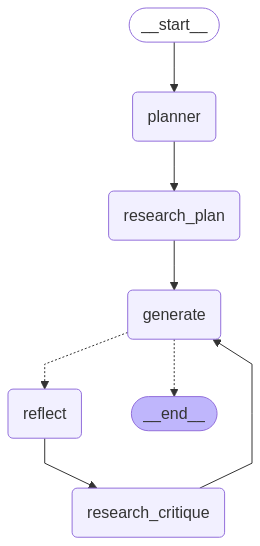

In [106]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

In [70]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd34-6fdd-8009-08071579a946'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd26-6dcd-8008-8f278bdf469f'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd12-6d8e-8007-d59cc90c22f7'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd12-6d8d-8006-37902f5b4508'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dcff-63a4-8005-134532d7f3f2'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dcea-6a19-8004-c2b06af4e91e'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e277-3182-63fa-8003-8fd48bfe8308'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e277-2306-6c99-8002-6b746aa92453'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkp

Start by grabbing a state.

In [71]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'count': 0}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-ee69-6618-8001-207dedc38fc1'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KWpTSFBOqT4mH0UCLmn2TeyO', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5ed7edad-1b87-4f7c-9fbc-1cbbe26f06be-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'q

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are *added* to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [72]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'count': -3, 'scratch': 'hello'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e276-ee69-6618-8001-207dedc38fc1'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KWpTSFBOqT4mH0UCLmn2TeyO', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5ed7edad-1b87-4f7c-9fbc-1cbbe26f06be-0', tool_calls=[{'name': 'tavily_search_resul

Now update the state. This creates a new entry at the *top*, or *latest* entry in memory. This will become the current state.

In [73]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02e27d-0df3-6af4-800a-023b2037e06f'}}

Current state is at the top. You can match the `thread_ts`.
Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.

In [74]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-0df3-6af4-800a-023b2037e06f'}}, metadata={'source': 'update', 'writes': {'Node2': {'count': -3, 'scratch': 'hello'}}, 'thread_id': '2', 'step': 10, 'parents': {}}, created_at='2025-05-11T05:21:39.137816+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd34-6fdd-8009-08071579a946'}}, tasks=(PregelTask(id='07613e70-5e75-085d-c5e4-59a2c578b658', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27b-dd34-6fdd-8009-08071579a946'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '2', 'step': 9

### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.

In [75]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02e27d-21a7-64ad-800b-c16da1fdc932'}}

In [76]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-21a7-64ad-800b-c16da1fdc932'}}, metadata={'source': 'update', 'writes': {'Node1': {'count': -3, 'scratch': 'hello'}}, 'thread_id': '2', 'step': 11, 'parents': {}}, created_at='2025-05-11T05:21:41.203678+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-0df3-6af4-800a-023b2037e06f'}}, tasks=(PregelTask(id='772621d7-5c2f-af7e-459f-a5e64d57711d', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-0df3-6af4-800a-023b2037e06f'}}, metadata={'source': 'update', 'writes': {'Node2': {'count': -3, 'scratch': 'hello'}}, 'thread_id'

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [77]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [78]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-3b1f-6c84-8010-ded4f8886537'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '2', 'step': 16, 'parents': {}}, created_at='2025-05-11T05:21:43.874470+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-3af8-61a9-800f-18d9f87d790c'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02e27d-3af8-61a9-800f-18d9f87d790c'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '2', 'step': 15, 'parents': {}}, created_at='2025-05-11T05:21:43.858218+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': 

# Essay Project

## Create helper function

In [80]:
%%writefile helper.py
import warnings
warnings.filterwarnings("ignore", message=".*TqdmWarning.*")
from dotenv import load_dotenv

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel
from tavily import TavilyClient
import os
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

class AgentState(TypedDict):
    task: str
    lnode: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    queries: List[str]
    revision_number: int
    max_revisions: int
    count: Annotated[int, operator.add]


class Queries(BaseModel):
    queries: List[str]

class ewriter():
    def __init__(self):
        self.model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.PLAN_PROMPT = ("You are an expert writer tasked with writing a high level outline of a short 3 paragraph essay. "
                            "Write such an outline for the user provided topic. Give the three main headers of an outline of "
                             "the essay along with any relevant notes or instructions for the sections. ")
        self.WRITER_PROMPT = ("You are an essay assistant tasked with writing excellent 3 paragraph essays. "
                              "Generate the best essay possible for the user's request and the initial outline. "
                              "If the user provides critique, respond with a revised version of your previous attempts. "
                              "Utilize all the information below as needed: \n"
                              "------\n"
                              "{content}")
        self.RESEARCH_PLAN_PROMPT = ("You are a researcher charged with providing information that can "
                                     "be used when writing the following essay. Generate a list of search "
                                     "queries that will gather "
                                     "any relevant information. Only generate 3 queries max.")
        self.REFLECTION_PROMPT = ("You are a teacher grading an 3 paragraph essay submission. "
                                  "Generate critique and recommendations for the user's submission. "
                                  "Provide detailed recommendations, including requests for length, depth, style, etc.")
        self.RESEARCH_CRITIQUE_PROMPT = ("You are a researcher charged with providing information that can "
                                         "be used when making any requested revisions (as outlined below). "
                                         "Generate a list of search queries that will gather any relevant information. "
                                         "Only generate 2 queries max.")
        self.tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
        builder = StateGraph(AgentState)
        builder.add_node("planner", self.plan_node)
        builder.add_node("research_plan", self.research_plan_node)
        builder.add_node("generate", self.generation_node)
        builder.add_node("reflect", self.reflection_node)
        builder.add_node("research_critique", self.research_critique_node)
        builder.set_entry_point("planner")
        builder.add_conditional_edges(
            "generate",
            self.should_continue,
            {END: END, "reflect": "reflect"}
        )
        builder.add_edge("planner", "research_plan")
        builder.add_edge("research_plan", "generate")
        builder.add_edge("reflect", "research_critique")
        builder.add_edge("research_critique", "generate")

        conn = sqlite3.connect(":memory:", check_same_thread=False)
        memory  = SqliteSaver(conn=conn) # Pass connection to saver
        self.graph = builder.compile(
            checkpointer=memory,
            interrupt_after=['planner', 'generate', 'reflect', 'research_plan', 'research_critique']
        )


    def plan_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ]
        response = self.model.invoke(messages)
        return {"plan": response.content,
               "lnode": "planner",
                "count": 1,
               }
    def research_plan_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ])
        content = state['content'] or []  # add to content
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
                "queries": queries.queries,
               "lnode": "research_plan",
                "count": 1,
               }
    def generation_node(self, state: AgentState):
        content = "\n\n".join(state['content'] or [])
        user_message = HumanMessage(
            content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
        messages = [
            SystemMessage(
                content=self.WRITER_PROMPT.format(content=content)
            ),
            user_message
            ]
        response = self.model.invoke(messages)
        return {
            "draft": response.content,
            "revision_number": state.get("revision_number", 1) + 1,
            "lnode": "generate",
            "count": 1,
        }
    def reflection_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.REFLECTION_PROMPT),
            HumanMessage(content=state['draft'])
        ]
        response = self.model.invoke(messages)
        return {"critique": response.content,
               "lnode": "reflect",
                "count": 1,
        }
    def research_critique_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state['critique'])
        ])
        content = state['content'] or []
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
               "lnode": "research_critique",
                "count": 1,
        }
    def should_continue(self, state):
        if state["revision_number"] > state["max_revisions"]:
            return END
        return "reflect"

import gradio as gr
import time

class writer_gui( ):
    def __init__(self, graph, share=False):
        self.graph = graph
        self.share = share
        self.partial_message = ""
        self.response = {}
        self.max_iterations = 10
        self.iterations = []
        self.threads = []
        self.thread_id = -1
        self.thread = {"configurable": {"thread_id": str(self.thread_id)}}
        #self.sdisps = {} #global
        self.demo = self.create_interface()

    def run_agent(self, start,topic,stop_after):
        #global partial_message, thread_id,thread
        #global response, max_iterations, iterations, threads
        if start:
            self.iterations.append(0)
            config = {'task': topic,"max_revisions": 2,"revision_number": 0,
                      'lnode': "", 'planner': "no plan", 'draft': "no draft", 'critique': "no critique",
                      'content': ["no content",], 'queries': "no queries", 'count':0}
            self.thread_id += 1  # new agent, new thread
            self.threads.append(self.thread_id)
        else:
            config = None
        self.thread = {"configurable": {"thread_id": str(self.thread_id)}}
        while self.iterations[self.thread_id] < self.max_iterations:
            self.response = self.graph.invoke(config, self.thread)
            self.iterations[self.thread_id] += 1
            self.partial_message += str(self.response)
            self.partial_message += f"\n------------------\n\n"
            ## fix
            lnode,nnode,_,rev,acount = self.get_disp_state()
            yield self.partial_message,lnode,nnode,self.thread_id,rev,acount
            config = None #need
            #print(f"run_agent:{lnode}")
            if not nnode:
                #print("Hit the end")
                return
            if lnode in stop_after:
                #print(f"stopping due to stop_after {lnode}")
                return
            else:
                #print(f"Not stopping on lnode {lnode}")
                pass
        return

    def get_disp_state(self,):
        current_state = self.graph.get_state(self.thread)
        lnode = current_state.values["lnode"]
        acount = current_state.values["count"]
        rev = current_state.values["revision_number"]
        nnode = current_state.next
        #print  (lnode,nnode,self.thread_id,rev,acount)
        return lnode,nnode,self.thread_id,rev,acount

    def get_state(self,key):
        current_values = self.graph.get_state(self.thread)
        if key in current_values.values:
            lnode,nnode,self.thread_id,rev,astep = self.get_disp_state()
            new_label = f"last_node: {lnode}, thread_id: {self.thread_id}, rev: {rev}, step: {astep}"
            return gr.update(label=new_label, value=current_values.values[key])
        else:
            return ""

    def get_content(self,):
        current_values = self.graph.get_state(self.thread)
        if "content" in current_values.values:
            content = current_values.values["content"]
            lnode,nnode,thread_id,rev,astep = self.get_disp_state()
            new_label = f"last_node: {lnode}, thread_id: {self.thread_id}, rev: {rev}, step: {astep}"
            return gr.update(label=new_label, value="\n\n".join(item for item in content) + "\n\n")
        else:
            return ""

    def update_hist_pd(self,):
        #print("update_hist_pd")
        hist = []
        # curiously, this generator returns the latest first
        for state in self.graph.get_state_history(self.thread):
            if state.metadata['step'] < 1:
                continue
            thread_ts = state.config['configurable']['thread_ts']
            tid = state.config['configurable']['thread_id']
            count = state.values['count']
            lnode = state.values['lnode']
            rev = state.values['revision_number']
            nnode = state.next
            st = f"{tid}:{count}:{lnode}:{nnode}:{rev}:{thread_ts}"
            hist.append(st)
        return gr.Dropdown(label="update_state from: thread:count:last_node:next_node:rev:thread_ts",
                           choices=hist, value=hist[0],interactive=True)

    def find_config(self,thread_ts):
        for state in self.graph.get_state_history(self.thread):
            config = state.config
            if config['configurable']['thread_ts'] == thread_ts:
                return config
        return(None)

    def copy_state(self,hist_str):
        ''' result of selecting an old state from the step pulldown. Note does not change thread.
             This copies an old state to a new current state.
        '''
        thread_ts = hist_str.split(":")[-1]
        #print(f"copy_state from {thread_ts}")
        config = self.find_config(thread_ts)
        #print(config)
        state = self.graph.get_state(config)
        self.graph.update_state(self.thread, state.values, as_node=state.values['lnode'])
        new_state = self.graph.get_state(self.thread)  #should now match
        new_thread_ts = new_state.config['configurable']['thread_ts']
        tid = new_state.config['configurable']['thread_id']
        count = new_state.values['count']
        lnode = new_state.values['lnode']
        rev = new_state.values['revision_number']
        nnode = new_state.next
        return lnode,nnode,new_thread_ts,rev,count

    def update_thread_pd(self,):
        #print("update_thread_pd")
        return gr.Dropdown(label="choose thread", choices=threads, value=self.thread_id,interactive=True)

    def switch_thread(self,new_thread_id):
        #print(f"switch_thread{new_thread_id}")
        self.thread = {"configurable": {"thread_id": str(new_thread_id)}}
        self.thread_id = new_thread_id
        return

    def modify_state(self,key,asnode,new_state):
        ''' gets the current state, modifes a single value in the state identified by key, and updates state with it.
        note that this will create a new 'current state' node. If you do this multiple times with different keys, it will create
        one for each update. Note also that it doesn't resume after the update
        '''
        current_values = self.graph.get_state(self.thread)
        current_values.values[key] = new_state
        self.graph.update_state(self.thread, current_values.values,as_node=asnode)
        return


    def create_interface(self):
        with gr.Blocks(theme=gr.themes.Default(spacing_size='sm',text_size="sm")) as demo:

            def updt_disp():
                ''' general update display on state change '''
                current_state = self.graph.get_state(self.thread)
                hist = []
                # curiously, this generator returns the latest first
                for state in self.graph.get_state_history(self.thread):
                    if state.metadata['step'] < 1:  #ignore early states
                        continue
                    s_thread_ts = state.config['configurable']['thread_ts']
                    s_tid = state.config['configurable']['thread_id']
                    s_count = state.values['count']
                    s_lnode = state.values['lnode']
                    s_rev = state.values['revision_number']
                    s_nnode = state.next
                    st = f"{s_tid}:{s_count}:{s_lnode}:{s_nnode}:{s_rev}:{s_thread_ts}"
                    hist.append(st)
                if not current_state.metadata: #handle init call
                    return{}
                else:
                    return {
                        topic_bx : current_state.values["task"],
                        lnode_bx : current_state.values["lnode"],
                        count_bx : current_state.values["count"],
                        revision_bx : current_state.values["revision_number"],
                        nnode_bx : current_state.next,
                        threadid_bx : self.thread_id,
                        thread_pd : gr.Dropdown(label="choose thread", choices=self.threads, value=self.thread_id,interactive=True),
                        step_pd : gr.Dropdown(label="update_state from: thread:count:last_node:next_node:rev:thread_ts",
                               choices=hist, value=hist[0],interactive=True),
                    }
            def get_snapshots():
                new_label = f"thread_id: {self.thread_id}, Summary of snapshots"
                sstate = ""
                for state in self.graph.get_state_history(self.thread):
                    for key in ['plan', 'draft', 'critique']:
                        if key in state.values:
                            state.values[key] = state.values[key][:80] + "..."
                    if 'content' in state.values:
                        for i in range(len(state.values['content'])):
                            state.values['content'][i] = state.values['content'][i][:20] + '...'
                    if 'writes' in state.metadata:
                        state.metadata['writes'] = "not shown"
                    sstate += str(state) + "\n\n"
                return gr.update(label=new_label, value=sstate)

            def vary_btn(stat):
                #print(f"vary_btn{stat}")
                return(gr.update(variant=stat))

            with gr.Tab("Agent"):
                with gr.Row():
                    topic_bx = gr.Textbox(label="Essay Topic", value="Pizza Shop")
                    gen_btn = gr.Button("Generate Essay", scale=0,min_width=80, variant='primary')
                    cont_btn = gr.Button("Continue Essay", scale=0,min_width=80)
                with gr.Row():
                    lnode_bx = gr.Textbox(label="last node", min_width=100)
                    nnode_bx = gr.Textbox(label="next node", min_width=100)
                    threadid_bx = gr.Textbox(label="Thread", scale=0, min_width=80)
                    revision_bx = gr.Textbox(label="Draft Rev", scale=0, min_width=80)
                    count_bx = gr.Textbox(label="count", scale=0, min_width=80)
                with gr.Accordion("Manage Agent", open=False):
                    checks = list(self.graph.nodes.keys())
                    checks.remove('__start__')
                    stop_after = gr.CheckboxGroup(checks,label="Interrupt After State", value=checks, scale=0, min_width=400)
                    with gr.Row():
                        thread_pd = gr.Dropdown(choices=self.threads,interactive=True, label="select thread", min_width=120, scale=0)
                        step_pd = gr.Dropdown(choices=['N/A'],interactive=True, label="select step", min_width=160, scale=1)
                live = gr.Textbox(label="Live Agent Output", lines=5, max_lines=5)

                # actions
                sdisps =[topic_bx,lnode_bx,nnode_bx,threadid_bx,revision_bx,count_bx,step_pd,thread_pd]
                thread_pd.input(self.switch_thread, [thread_pd], None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
                step_pd.input(self.copy_state,[step_pd],None).then(
                              fn=updt_disp, inputs=None, outputs=sdisps)
                gen_btn.click(vary_btn,gr.Number("secondary", visible=False), gen_btn).then(
                              fn=self.run_agent, inputs=[gr.Number(True, visible=False),topic_bx,stop_after], outputs=[live],show_progress=True).then(
                              fn=updt_disp, inputs=None, outputs=sdisps).then(
                              vary_btn,gr.Number("primary", visible=False), gen_btn).then(
                              vary_btn,gr.Number("primary", visible=False), cont_btn)
                cont_btn.click(vary_btn,gr.Number("secondary", visible=False), cont_btn).then(
                               fn=self.run_agent, inputs=[gr.Number(False, visible=False),topic_bx,stop_after],
                               outputs=[live]).then(
                               fn=updt_disp, inputs=None, outputs=sdisps).then(
                               vary_btn,gr.Number("primary", visible=False), cont_btn)

            with gr.Tab("Plan"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                plan = gr.Textbox(label="Plan", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("plan", visible=False), outputs=plan)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("plan", visible=False),
                                                          gr.Number("planner", visible=False), plan],outputs=None).then(
                                 fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("Research Content"):
                refresh_btn = gr.Button("Refresh")
                content_bx = gr.Textbox(label="content", lines=10)
                refresh_btn.click(fn=self.get_content, inputs=None, outputs=content_bx)
            with gr.Tab("Draft"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                draft_bx = gr.Textbox(label="draft", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("draft", visible=False), outputs=draft_bx)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("draft", visible=False),
                                                          gr.Number("generate", visible=False), draft_bx], outputs=None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("Critique"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                critique_bx = gr.Textbox(label="Critique", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("critique", visible=False), outputs=critique_bx)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("critique", visible=False),
                                                          gr.Number("reflect", visible=False),
                                                          critique_bx], outputs=None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("StateSnapShots"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                snapshots = gr.Textbox(label="State Snapshots Summaries")
                refresh_btn.click(fn=get_snapshots, inputs=None, outputs=snapshots)
        return demo

    def launch(self, share=None):
        if port := os.getenv("PORT1"):
            self.demo.launch(share=True, server_port=int(port), server_name="0.0.0.0")
        else:
            self.demo.launch(share=self.share)

Overwriting helper.py


## Start Project

In [81]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3


In [82]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [83]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [84]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [85]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [86]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [87]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [88]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [89]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

C:\Users\Smith\anaconda3\envs\langenv\Lib\site-packages\IPython\core\interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [91]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [92]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [93]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


In [94]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [95]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [96]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [97]:
builder = StateGraph(AgentState)

In [98]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [99]:
builder.set_entry_point("planner")

In [100]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)


In [101]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [102]:
graph = builder.compile(checkpointer=memory)

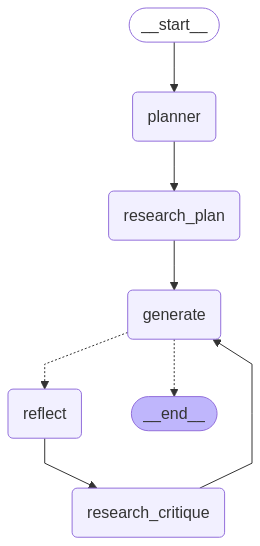

In [105]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

In [108]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [],  # Add the 'content' key with an empty list as the initial value
}, thread):
    print(s)


{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Interoperability\n    E. Performance\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Future outlook and potential developments in the field\n\nNotes:\n- Ensure to provide clear definitions and explanations of both Langchain and Langsmith.\n- Include specific examples of use cases and applications for each technology.\n- Use comparat

## Essay Writer Interface

In [109]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [110]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
